In [3]:
def getDist(cord1,cord2):
	return (
		(float(cord1[0])-float(cord2[0]))**2+
		(float(cord1[1])-float(cord2[1]))**2+
		(float(cord1[2])-float(cord2[2]))**2)**0.5 * 10

class gro:    # ndx = {chineID : (start atomNdx, end atomNdx)}
    def __init__(self, groFile):
        from tqdm import tqdm
        self.version = "groObj V.1"
        self.type = "Multi Chains"
        with open(groFile, "r") as gro:
            groLines = gro.readlines()
            self.atomNum = groLines[1]
        self.frames = {} # { frameNdx : { atomNdx : { resNdx : x, coord : (x, y, x) } } }
        frameNdx = 0
        atomDic = {}
        resNdx = groLines[2].split()[:-3]
        for line in tqdm(groLines[2:]):
            line_list = line.split()
            if len(line_list) == 3:
                self.frames[frameNdx] = atomDic
                frameNdx = frameNdx + 1
                atomDic = {}
            elif "Title" not in line and len(line.split()) > 3:
                #print(line)
                atomNdx = int(line.split()[2])
                atomDic[atomNdx] = {
                    "resNdx" : int(line.split()[0][:-3]),
                    "coord" : (
                        float(line.split()[3]),
                        float(line.split()[4]),
                        float(line.split()[5])
                    )
                }
    def getRes(self, ndx):
      frameDic = {} # { frameNdx : { resNdx : { atomNdx : (coord) } } }
      for frame in self.frames.items():# { frameNdx : { atomNdx : { resNdx : x, coord : (x, y, x) } } }
          frameNdx = frame[0]
          atomDic = frame[1]
          resDic = {}
          for atomNdx in range(ndx[0], ndx[1]+1):
              resNdx = atomDic[atomNdx]["resNdx"]
              coord = atomDic[atomNdx]["coord"]
              if resNdx not in list(resDic.keys()):
                  resDic[resNdx] = [coord]
              else:
                  resDic[resNdx].append(coord)
          frameDic[frameNdx] = resDic
      return frameDic

def contactPerFrame(frameNdx, proAtomNdx, ligAtomNdx, groObj):
    with open(groObj, "rb") as groDataFile:
        groData = pickle.load(groDataFile)
    ligRes = groData.getRes(ligAtomNdx)[frameNdx]
    proRes = groData.getRes(proAtomNdx)[frameNdx]
    #print(proRes[15])
    distDic = {}
    ligCoords = []
    for coord in ligRes.items():
        ligCoords = ligCoords + coord[1]
    
    for resID in proRes.keys():
        tmpDislist = []
        for resCoords in proRes[resID]:
            for ligCoord in ligCoords:
                #print(resAtom)
                tmpDislist.append(
                    getDist(resCoords, ligCoord)
                )
        distDic[resID] = round(min(tmpDislist), 3)
    #print(distDic)
    distDic["frameNdx"] = frameNdx
    dataFrame = pd.DataFrame([distDic])
    return dataFrame


In [5]:
groData = gro("../3_md/fit.gro")
import pickle
with open("groData.pkl", "wb") as groDataFile:
    pickle.dump(groData, groDataFile)

100%|██████████| 2941937/2941937 [00:26<00:00, 109914.76it/s]


In [5]:
import pandas as pd
import pickle

frameNdx = 0
proAtomNdx = (1, 2863)
ligAtomNdx = (2864, 2936)
contactPerFrame(frameNdx, proAtomNdx, ligAtomNdx, "groData.pkl")


,15,16,17,18,19,20,21,22,23,24,...,184,185,186,187,188,189,190,191,192,193
0,14.583,13.6,11.07,6.499,3.643,9.554,9.885,3.598,6.807,2.631,...,12.467,10.644,2.477,9.897,7.926,11.843,15.748,13.946,9.733,12.82


In [8]:
import pickle
import pandas as pd
from tqdm import tqdm
#print("> loading data")
#with open("groData.pkl", "rb") as groDataFile:
#    groData = pickle.load(groDataFile)
#print("> loaded data")
#for item in groData.frames[1000][15].items():
#    print(item)
from joblib import Parallel, delayed
print("> joblib imported")
proAtomNdx = (1, 2863)
ligAtomNdx = (2864, 2936)
print("> startting multiProcessing")
results = Parallel(
    n_jobs=64, backend='multiprocessing'
    )(delayed(contactPerFrame)(frameNdx, proAtomNdx, ligAtomNdx, "groData.pkl") for frameNdx in tqdm(range(0,1001)))
print("> multiProcessing done")
results = pd.concat(results, axis=0, ignore_index=True)
results = results.sort_values(by=results.columns[-1], ascending=True)
with open("con_results.pkl", "wb") as con_results:
    pickle.dump(results, con_results)
print("> done")

> joblib imported
> startting multiProcessing



  6%|▋         | 63/1001 [02:47<41:32,  2.66s/it]















100%|██████████| 1001/1001 [07:20<00:00,  2.27it/s]


> multiProcessing done
> done


In [1]:
import pickle
import pandas as pd
with open("con_results.pkl", "rb") as con_results:
    results = pickle.load(con_results)
(results)

,15,16,17,18,19,20,21,22,23,24,...,185,186,187,188,189,190,191,192,193,frameNdx
0,14.583,13.600,11.070,6.499,3.643,9.554,9.885,3.598,6.807,2.631,...,10.644,2.477,9.897,7.926,11.843,15.748,13.946,9.733,12.820,0
1,18.717,15.897,13.781,11.703,6.377,9.687,11.882,6.251,6.633,2.408,...,10.482,2.097,9.975,10.181,13.722,17.444,16.349,13.056,15.926,1
2,18.786,16.616,13.678,10.942,5.356,9.917,11.150,6.257,6.079,2.831,...,11.472,3.255,10.709,9.328,12.259,16.722,16.608,11.402,13.933,2
3,18.367,15.952,13.544,10.895,6.172,9.392,11.473,6.122,6.604,2.708,...,11.824,3.711,11.822,8.853,13.853,18.090,17.948,12.359,13.699,3
4,19.024,16.575,13.861,10.832,6.446,9.921,11.244,5.842,6.425,2.287,...,11.621,3.730,11.218,11.198,14.113,18.417,17.113,12.305,17.157,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,18.982,15.750,13.023,10.231,4.794,10.426,10.868,6.270,6.302,3.236,...,14.109,7.213,14.444,13.005,12.651,14.143,18.472,19.295,18.595,996
997,18.684,15.728,12.731,10.080,4.635,10.144,10.867,6.127,6.216,2.460,...,14.343,7.085,14.307,14.600,13.918,15.635,20.543,21.596,25.531,997
998,19.602,16.546,13.497,10.667,4.665,10.626,10.925,6.228,6.728,3.113,...,12.520,6.197,13.130,13.409,12.863,14.375,19.884,21.040,22.723,998
999,18.779,15.216,12.586,9.761,4.916,9.447,10.485,5.995,6.954,2.103,...,13.388,7.580,15.242,15.702,14.016,15.983,21.058,24.015,23.178,999


In [15]:
heatDat = results.iloc[:, :-1].T
heatDat

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
15,14.583,18.717,18.786,18.367,19.024,19.542,18.671,18.485,18.956,18.940,...,18.542,17.841,19.219,18.344,18.446,18.982,18.684,19.602,18.779,19.210
16,13.600,15.897,16.616,15.952,16.575,16.551,15.916,16.620,15.890,16.868,...,15.124,15.090,16.500,15.597,15.284,15.750,15.728,16.546,15.216,15.876
17,11.070,13.781,13.678,13.544,13.861,14.027,13.696,13.857,13.185,13.651,...,12.480,12.203,13.566,12.852,12.666,13.023,12.731,13.497,12.586,13.112
18,6.499,11.703,10.942,10.895,10.832,11.669,11.443,11.064,10.974,11.180,...,9.984,9.711,11.017,10.046,10.615,10.231,10.080,10.667,9.761,10.702
19,3.643,6.377,5.356,6.172,6.446,7.142,7.327,7.310,7.804,7.088,...,4.495,4.802,5.819,5.026,5.236,4.794,4.635,4.665,4.916,4.560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,11.843,13.722,12.259,13.853,14.113,13.434,14.715,13.978,15.265,17.712,...,13.021,13.179,13.525,14.158,14.027,12.651,13.918,12.863,14.016,13.804
190,15.748,17.444,16.722,18.090,18.417,17.756,18.972,17.775,18.683,21.760,...,13.338,12.737,11.547,14.444,13.615,14.143,15.635,14.375,15.983,15.796
191,13.946,16.349,16.608,17.948,17.113,17.189,16.488,16.826,16.697,20.768,...,18.617,18.487,19.095,20.191,20.565,18.472,20.543,19.884,21.058,20.321
192,9.733,13.056,11.402,12.359,12.305,12.246,12.544,14.108,14.622,15.961,...,22.200,21.624,21.970,22.362,22.099,19.295,21.596,21.040,24.015,23.089


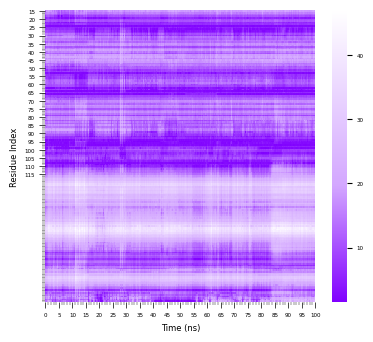

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

df = pd.DataFrame(heatDat)

# 创建自定义颜色映射
# 5以下颜色越小越深，大于等于5的白色
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, "#8000FF"), (0.4, "#D3A7FF"), (1, "#ffffff")],
    N=512
)
#norm = mcolors.Normalize(vmin=0, vmax=5)
#cbar_kws={'ticks': []}

# 绘制热图
fig, ax = plt.subplots(figsize=(4, 3.5) )  # 设置图形大小
sns.heatmap(df, annot=False, cmap=cmap)#, norm=norm, fmt=".1f", cbar_kws=cbar_kws)  # 设置颜色条的标签
plt.yticks([x+0.5 for x in range(0, 101, 5)], range(15, 116, 5))
plt.xticks([x for x in range(0,1001,50)],[ x for x in range(0,101,5)],rotation=0)
ax.tick_params(axis="y",reset=True, which="both", direction="out", width=0.5, length=4,labelsize=4,right=False)
ax.tick_params(axis="y", which="minor",reset=True, direction="out", width=0.3, length=2,zorder=1,right=False)
ax.tick_params(axis="x", which="major", direction="out", width=0.5, length=4, right=False,labelsize=4)
ax.tick_params(axis="x", which="minor", direction="out", width=0.3, length=2, right=False)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
#for i in range(0, 100, 1):
#    ax.axhline(i, color='grey',linewidth=0.1)
    #ax2.axvline(i, color='black',linewidth=0.2)

#plt.text(1115, 17,'d > 5Å', fontsize=4, rotation=-90)
#plt.text(1115, 46,'5Å ≥ d > 4Å', fontsize=4, rotation=-90)
#plt.text(1115, 71,'4Å ≥ d > 3Å', fontsize=4, rotation=-90)
#plt.text(1115, 92,'3Å ≥ d', fontsize=4, rotation=-90)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=4)  # 设置颜色条刻度的字体大小

plt.tight_layout(pad=1.5)
plt.ylabel("Residue Index", fontsize=6)
plt.xlabel("Time (ns)", fontsize=6)
plt.savefig("HeatMap.png", dpi=600)
plt.savefig("HeatMap.svg", dpi=600)
plt.show()


In [17]:
heatDat.iloc[0:101,:]

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
15,14.583,18.717,18.786,18.367,19.024,19.542,18.671,18.485,18.956,18.940,...,18.542,17.841,19.219,18.344,18.446,18.982,18.684,19.602,18.779,19.210
16,13.600,15.897,16.616,15.952,16.575,16.551,15.916,16.620,15.890,16.868,...,15.124,15.090,16.500,15.597,15.284,15.750,15.728,16.546,15.216,15.876
17,11.070,13.781,13.678,13.544,13.861,14.027,13.696,13.857,13.185,13.651,...,12.480,12.203,13.566,12.852,12.666,13.023,12.731,13.497,12.586,13.112
18,6.499,11.703,10.942,10.895,10.832,11.669,11.443,11.064,10.974,11.180,...,9.984,9.711,11.017,10.046,10.615,10.231,10.080,10.667,9.761,10.702
19,3.643,6.377,5.356,6.172,6.446,7.142,7.327,7.310,7.804,7.088,...,4.495,4.802,5.819,5.026,5.236,4.794,4.635,4.665,4.916,4.560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,5.068,5.536,6.290,6.972,7.261,7.372,8.593,8.350,8.519,11.611,...,10.422,11.111,12.110,11.557,11.685,11.295,10.975,11.013,11.998,11.570
112,8.729,8.811,10.207,10.675,10.967,11.162,12.241,12.319,12.348,15.134,...,14.321,14.868,15.902,15.275,15.348,15.121,14.750,14.931,15.747,15.385
113,9.572,9.647,10.490,11.736,11.618,11.604,12.947,13.233,13.501,16.131,...,15.033,15.590,16.245,15.889,15.327,15.556,15.362,14.837,16.035,15.614
114,10.346,10.802,11.917,12.129,12.213,11.386,12.405,13.591,14.159,15.400,...,14.724,13.946,14.865,14.992,14.159,14.542,14.238,13.944,14.535,14.907


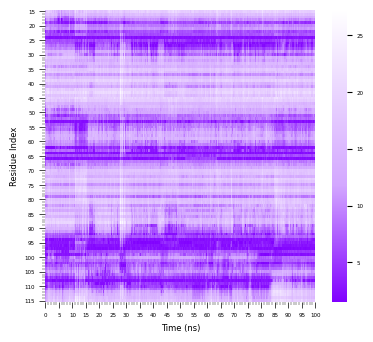

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

df = pd.DataFrame(heatDat.iloc[0:101,:])

# 创建自定义颜色映射
# 5以下颜色越小越深，大于等于5的白色
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, "#8000FF"), (0.4, "#D3A7FF"), (1, "#ffffff")],
    N=512
)
#norm = mcolors.Normalize(vmin=0, vmax=5)
#cbar_kws={'ticks': []}

# 绘制热图
fig, ax = plt.subplots(figsize=(4, 3.5) )  # 设置图形大小
sns.heatmap(df, annot=False, cmap=cmap)#, norm=norm, fmt=".1f", cbar_kws=cbar_kws)  # 设置颜色条的标签
plt.yticks([x+0.5 for x in range(0, 101, 5)], range(15, 116, 5))
plt.xticks([x for x in range(0,1001,50)],[ x for x in range(0,101,5)],rotation=0)
ax.tick_params(axis="y",reset=True, which="both", direction="out", width=0.5, length=4,labelsize=4,right=False)
ax.tick_params(axis="y", which="minor",reset=True, direction="out", width=0.3, length=2,zorder=1,right=False)
ax.tick_params(axis="x", which="major", direction="out", width=0.5, length=4, right=False,labelsize=4)
ax.tick_params(axis="x", which="minor", direction="out", width=0.3, length=2, right=False)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
#for i in range(0, 100, 1):
#    ax.axhline(i, color='grey',linewidth=0.1)
    #ax2.axvline(i, color='black',linewidth=0.2)

#plt.text(1115, 17,'d > 5Å', fontsize=4, rotation=-90)
#plt.text(1115, 46,'5Å ≥ d > 4Å', fontsize=4, rotation=-90)
#plt.text(1115, 71,'4Å ≥ d > 3Å', fontsize=4, rotation=-90)
#plt.text(1115, 92,'3Å ≥ d', fontsize=4, rotation=-90)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=4)  # 设置颜色条刻度的字体大小

plt.tight_layout(pad=1.5)
plt.ylabel("Residue Index", fontsize=6)
plt.xlabel("Time (ns)", fontsize=6)
plt.savefig("HeatMap.png", dpi=600)
plt.savefig("HeatMap.svg", dpi=600)
plt.show()
